# Ethnobotany informs chemical diversity 

### Import modules

In [1]:
from collections import defaultdict
import random

import pandas as pd
from tqdm import tqdm

# Cheminformatics
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit import RDLogger  

from rdkit import Chem
from rdkit.Chem import MolFromSmiles, Descriptors
# Viz
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
RDLogger.DisableLog('rdApp.*')

In [3]:
%matplotlib inline

In [4]:
random.seed(123)

In [5]:
mpl.rcParams['figure.dpi'] = 360
sns.set_style("whitegrid")

In [6]:
DATA_DIR = '../data/processed'

Load plant-disease evidences

In [7]:
plant_disease_df = pd.read_csv(
    f'{DATA_DIR}/plant_disease_associations.tsv.gz',
    compression='gzip',
    sep='\t',
    usecols=[
        'plant_curie',
        'disease_curie',
    ]
)

In [8]:
plant_disease_df.head(1)

,plant_curie,disease_curie
0,ncbitaxon:3369,mondo:0005324


In [9]:
plant_disease_dict = defaultdict(set)

for plant_curie, disease_curie in tqdm(plant_disease_df.values):
    plant_disease_dict[plant_curie].add(disease_curie)

100%|██████████| 97066/97066 [00:00<00:00, 705895.13it/s]


In [10]:
medicinal_plants = set(plant_disease_df.plant_curie.unique())

In [11]:
len(medicinal_plants)

6048

Load plant-chemical evidences

In [12]:
plant_chemical_df = pd.read_csv(
    f'{DATA_DIR}/plant_chemical_associations.tsv.zip',
    compression='zip',
    sep='\t',
    usecols=[
        'plant_curie',
        'chemical_curie',
    ]
)

In [13]:
plant_chemical_df.head(1)

,plant_curie,chemical_curie
0,ncbitaxon:1000425,pubchem.compound:3527


In [14]:
len(plant_chemical_df.chemical_curie.unique())

71179

In [15]:
plant_ids = set(plant_chemical_df.plant_curie.unique())

Get SMILES

In [16]:
smiles_df = pd.read_csv(
    '../data/mapping/smiles.tsv.zip',
    sep='\t',
    compression='zip',
)

In [17]:
smiles_df.head(1)

,pubchem id,smiles
0,pubchem:3527,CC(=CCCC1(C(CC2(C(=O)C(=C(C3=CC(=C(C=C3)O)O)O)...


In [18]:
smiles_df.shape

(323369, 2)

In [19]:
smiles_from_pubchem_id = {}
skipped_murcko = 0
skipped_smiles = 0
skipped_wt = 0

smiles_to_property_dict = {}

for pubchem_id, smiles in tqdm(smiles_df.values):
        
    if pubchem_id.startswith('pubchem:'):
        pubchem_id = pubchem_id.replace('pubchem:', 'pubchem.compound:')
        
    """Calculate some properties"""
    try:
        molecule = MolFromSmiles(smiles)
    except:
        skipped_smiles += 1
        continue
    try:
        molecular_weight = Descriptors.ExactMolWt(molecule)
    except:
        skipped_wt += 1
        continue  

    logp = Descriptors.MolLogP(molecule)
    topological_surface_area_mapping = Chem.QED.properties(molecule).PSA
    fsp3 = Chem.Lipinski.FractionCSP3(molecule)
    
    smiles_to_property_dict[pubchem_id] = {
        'molecular_weight': molecular_weight,
        'logp': logp,
        'topological_surface_area_mapping': topological_surface_area_mapping,
        'fsp3': fsp3,
    }
    
    """Murcko scaffold"""
    try:
        murcko_smiles = GetScaffoldForMol(molecule)
    except:
        skipped_murcko += 1
        continue
        
    smiles_from_pubchem_id[pubchem_id] = murcko_smiles

100%|██████████| 323369/323369 [15:40<00:00, 343.74it/s]


In [20]:
len(smiles_from_pubchem_id), skipped_murcko, skipped_smiles, skipped_wt

(69954, 0, 0, 0)

Prepare plant-chemicals dicts

In [21]:
plant_chem_dict = defaultdict(set)
plant_scaffolds_dict = defaultdict(set)

chemicals_to_plant_dict = defaultdict(set)

for plant_curie, chemical_curie in tqdm(plant_chemical_df.values):
    
    plant_chem_dict[plant_curie].add(chemical_curie)
    chemicals_to_plant_dict[chemical_curie].add(plant_curie)
    
    if chemical_curie in smiles_from_pubchem_id:
        plant_scaffolds_dict[plant_curie].add(smiles_from_pubchem_id[chemical_curie])

100%|██████████| 330655/330655 [00:00<00:00, 354726.81it/s]


### Explore distributions

We will apply a filter to avoid artifacts caused by these chemical outliers (chemicals present in a lot of plants)

In [24]:
# Remove chemicals that are prenent in more than 200 plants

promiscuous_chemicals = [
    chemical
    for chemical, plants in chemicals_to_plant_dict.items()
    if len(plants) > 200
]

plant_chem_dict = {
    plant: {
        chemical
        for chemical in chemicals
        if chemical not in promiscuous_chemicals
    }
    for plant, chemicals in plant_chem_dict.items()
}

Number of chemicals per plant

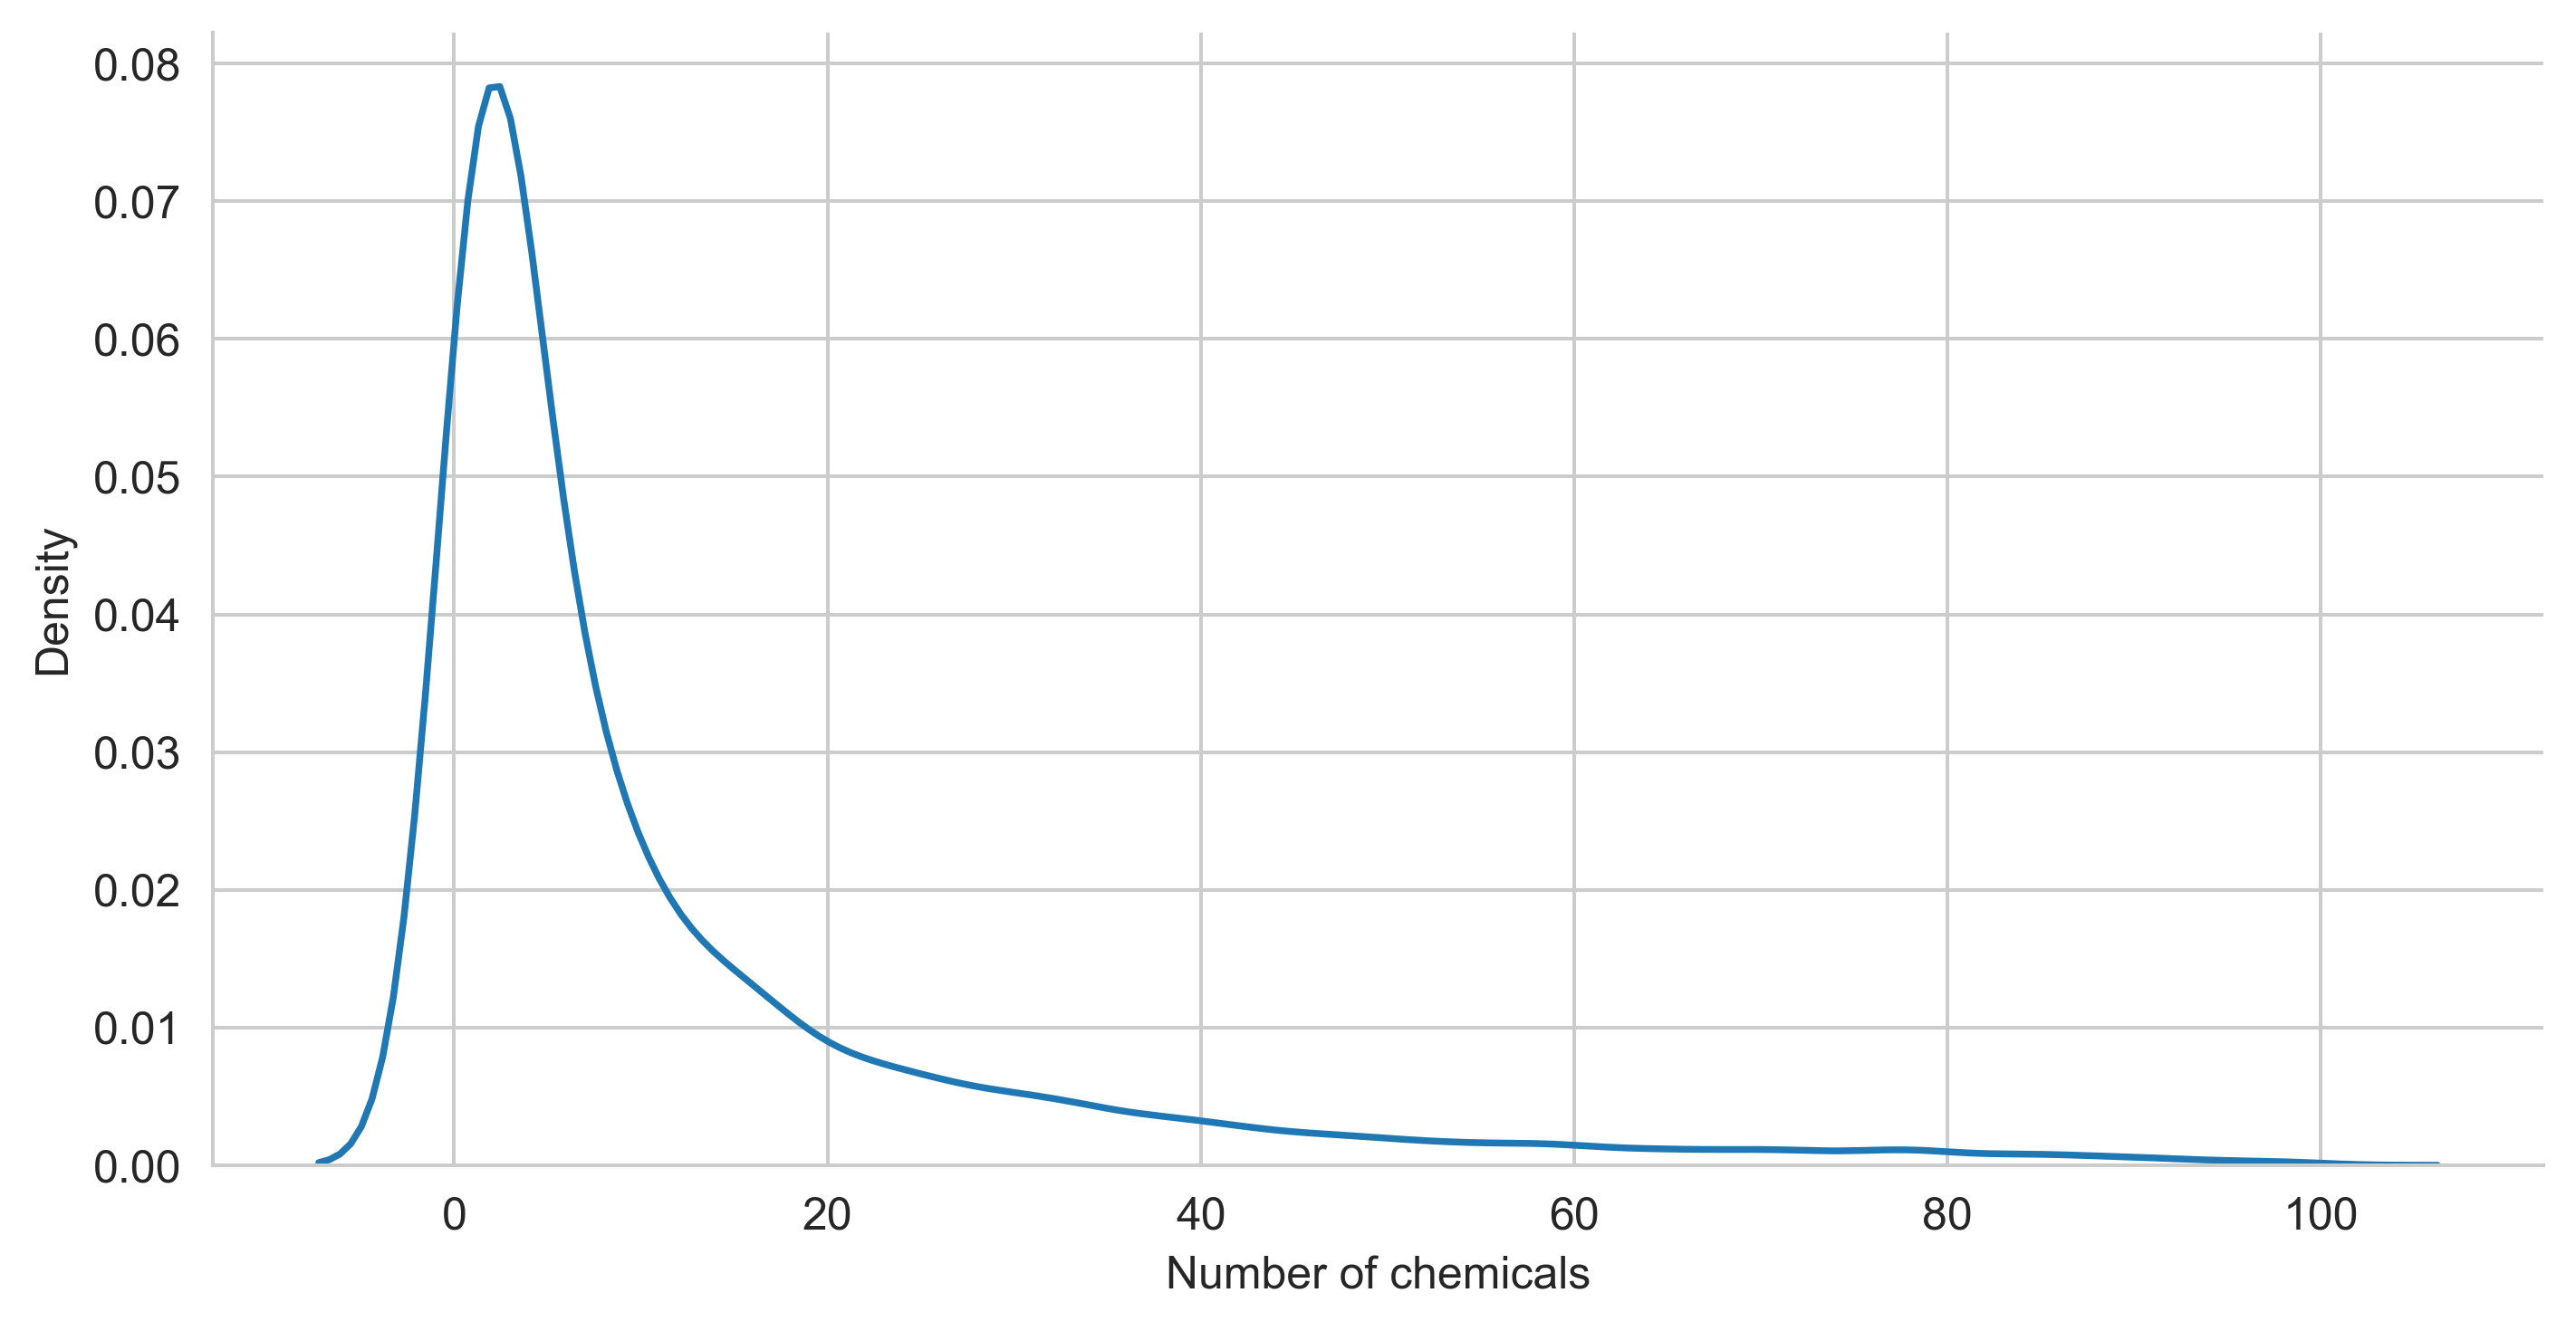

In [25]:
g = sns.displot(
    [
        len(chemicals)
        for chemicals in plant_chem_dict.values()
        if len(chemicals) < 100
    ],
    kind="kde",
    height=4,
    aspect=2
)

g.set_axis_labels("Number of chemicals", "Density")
g.set_titles("Distribution of chemicals per plant (max 100)")

plt.show()

Number of plants per chemical after filtering

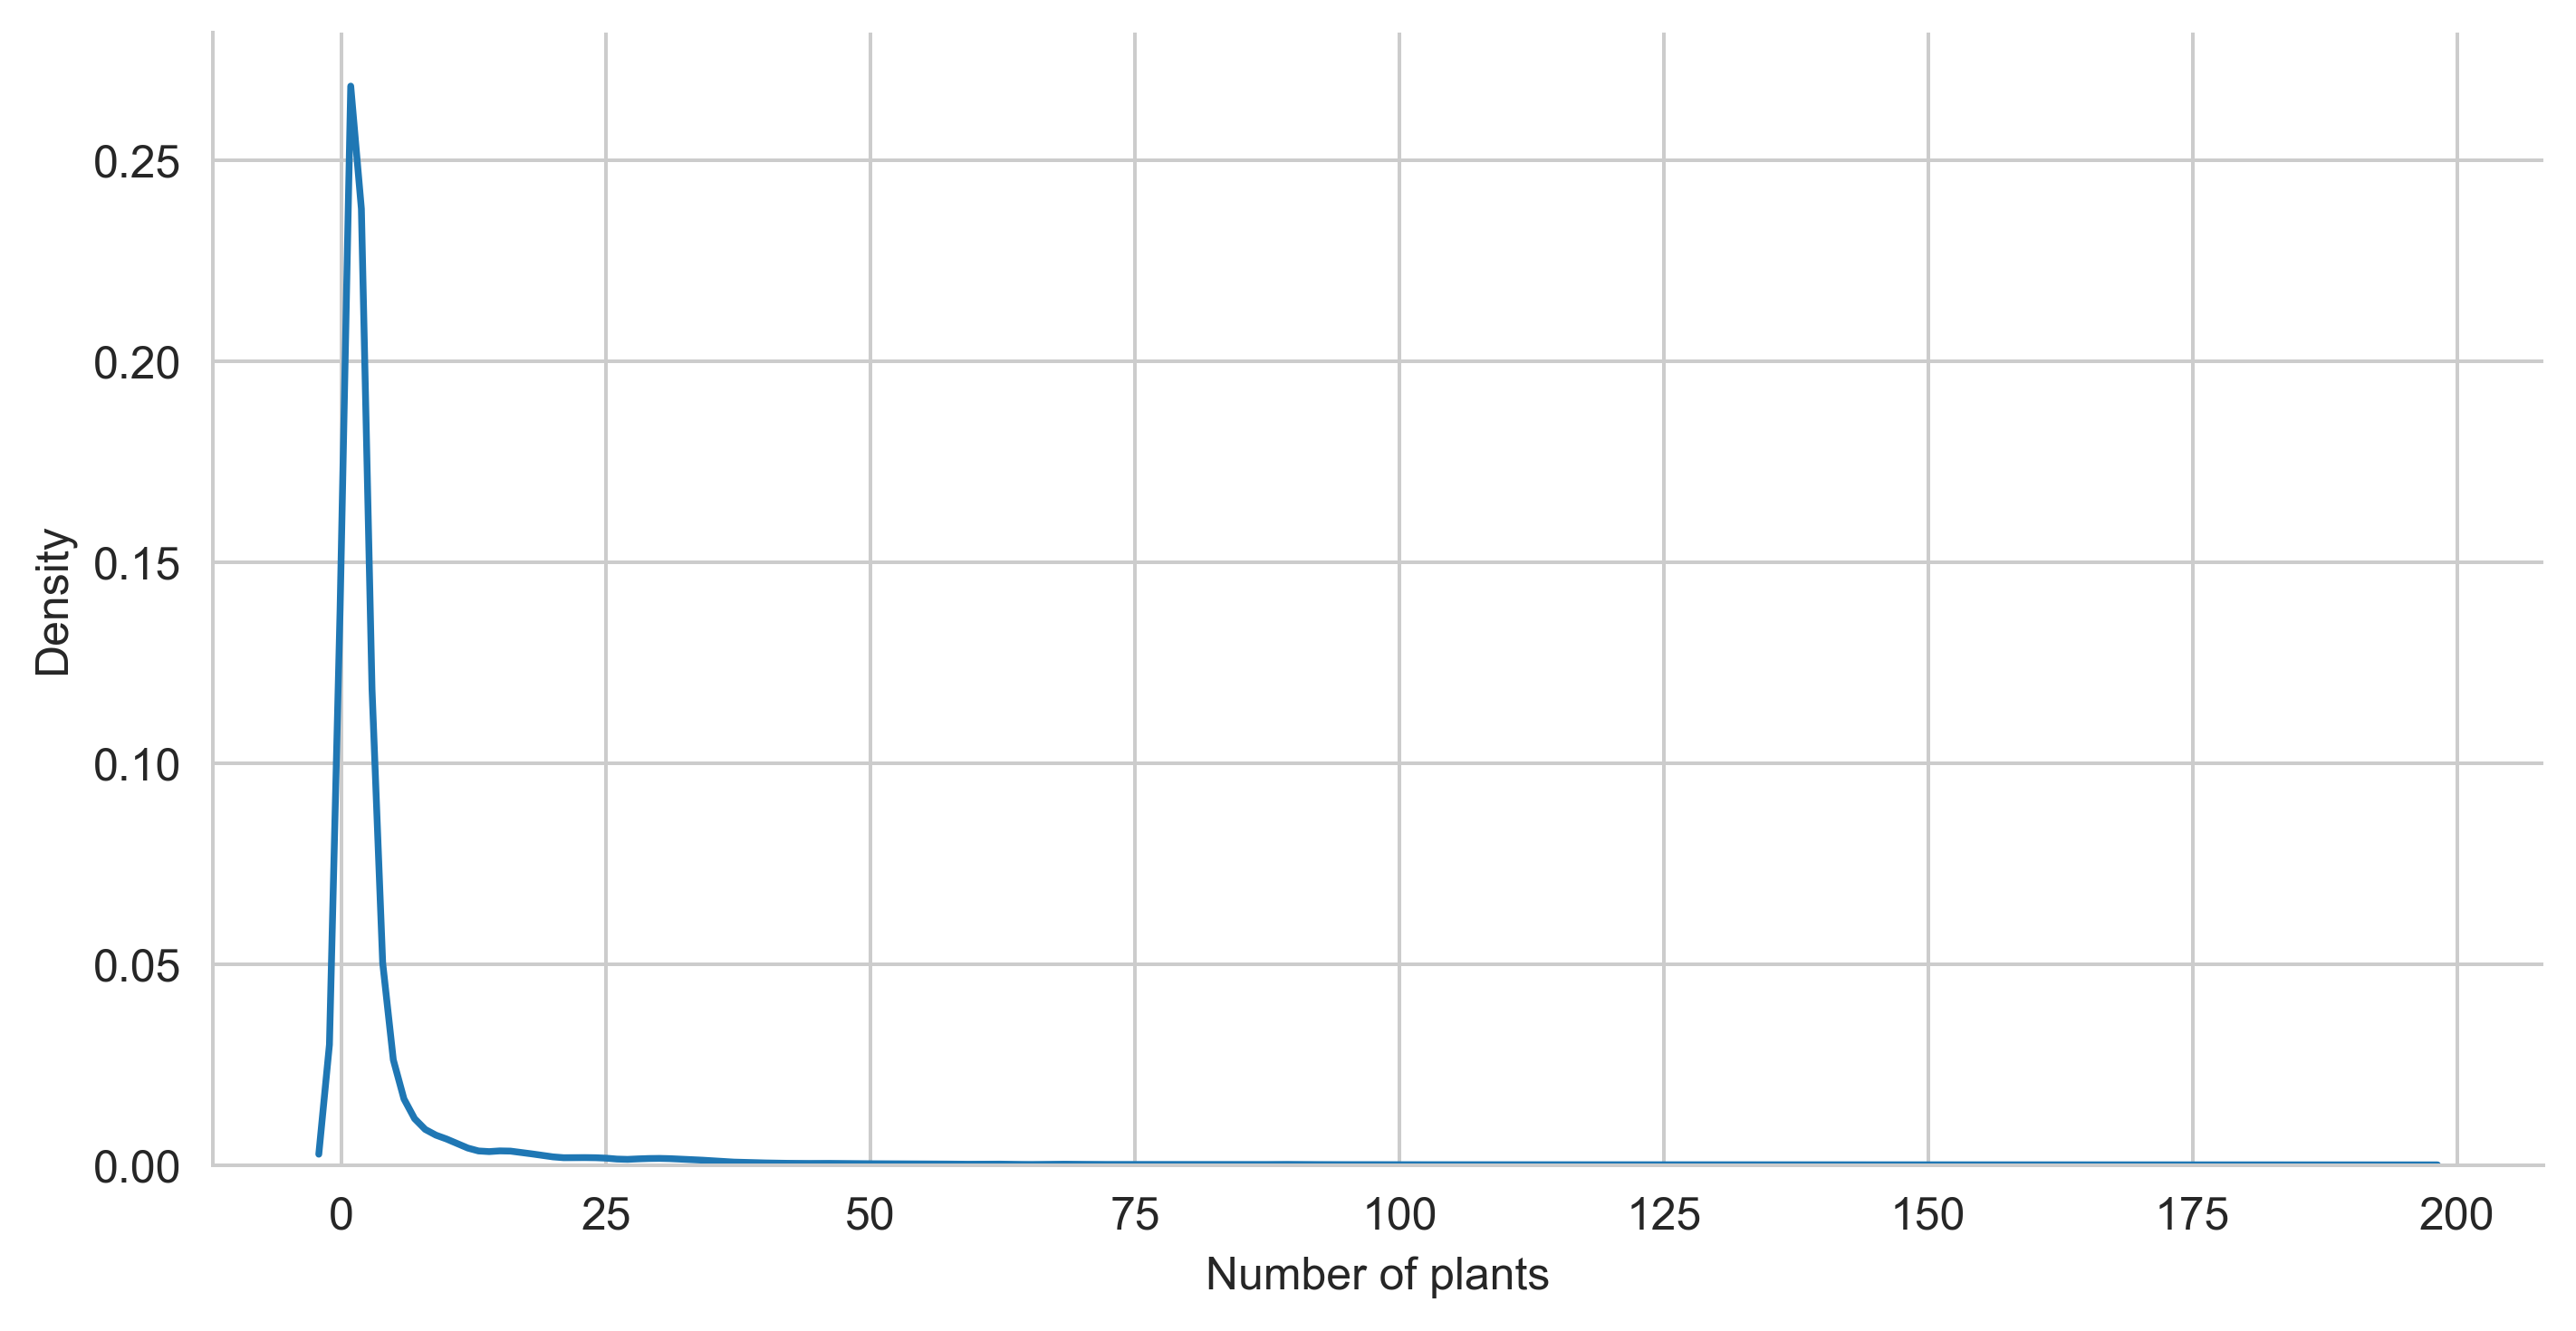

In [26]:
g = sns.displot(
    [
        len(plants)
        for plants in chemicals_to_plant_dict.values()
        if len(plants) < 200
    ],
    kind="kde",
    height=4,
    aspect=2
)

g.set_axis_labels("Number of plants", "Density")
g.set_titles("Distribution of plants per chemical")

plt.show()

## Finding a set of 100 medicinal plants maximizing the diseases they treat

Simple approach: Take the 100 plants with the largest of therapeutic indications 

In [27]:
def get_top_plants_with_more_therapeutic_usages(plant_diseases_dict, plants_with_known_chemicals):
    sorted_plants = sorted(plant_diseases_dict, key=lambda k: len(plant_diseases_dict[k]), reverse=True)
      
    top_plants = []
        
    for plant in sorted_plants:
                
        # Ensure the plants have chemicals
        if plant not in plants_with_known_chemicals:
            continue
        
        top_plants.append(plant)

        if len(top_plants) == 100:
            break
                  
    return top_plants

In [28]:
top_100_plants = get_top_plants_with_more_therapeutic_usages(
    plant_diseases_dict=plant_disease_dict,
    # Since we have filtered out some plants that have a lot of chemicals
    # we have to skip them from the analysis
    plants_with_known_chemicals=plant_chem_dict.keys()
)

In [29]:
len(top_100_plants)

100

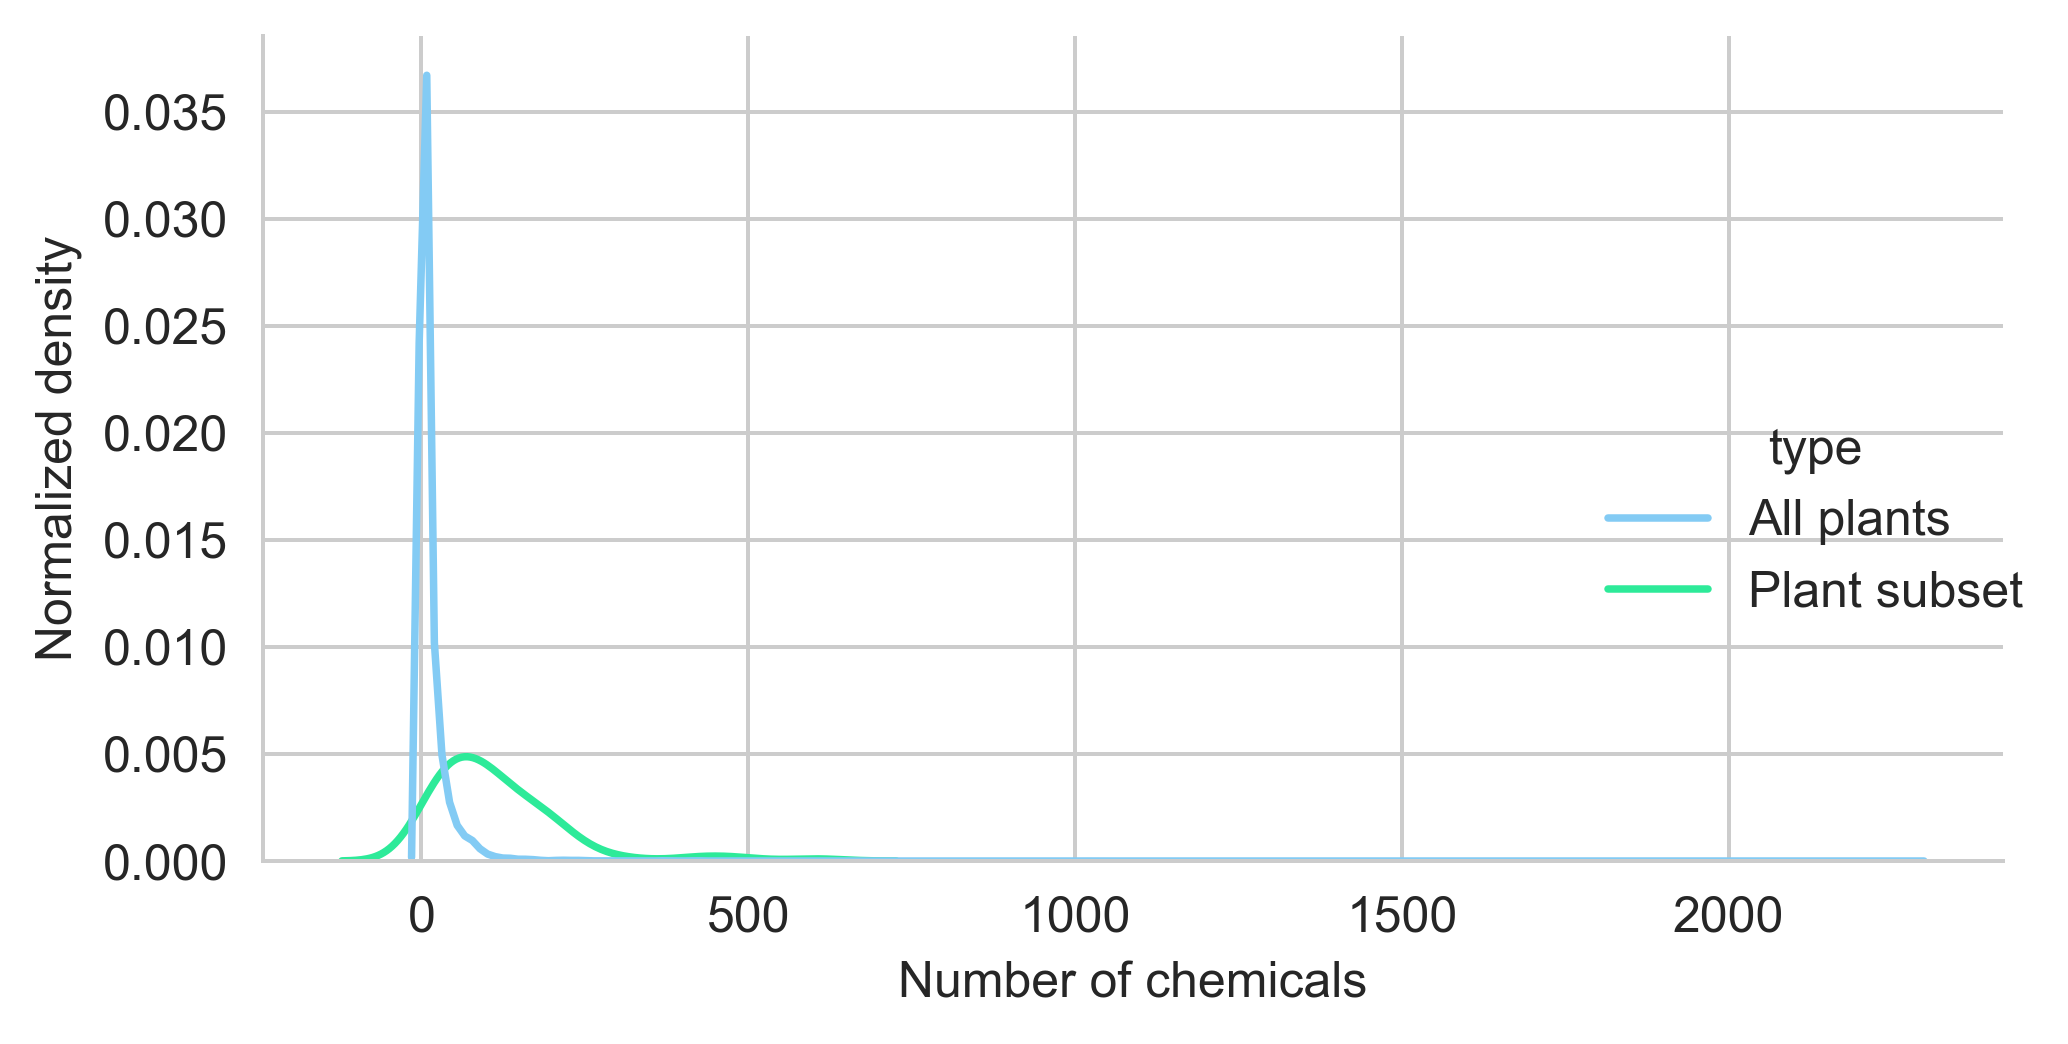

In [30]:
df1 = pd.DataFrame([
    {
        'type': 'All plants',
        '# chemicals': len(chemicals)
    }
    for plant, chemicals in plant_chem_dict.items()
    if plant not in top_100_plants
    # Note this also includes other medicinal plants as well
])

df2 = pd.DataFrame([
    {
        'type': 'Plant subset',
        '# chemicals': len(chemicals)
    }
    for plant, chemicals in plant_chem_dict.items()
    if plant in top_100_plants
])

joined_df = pd.concat([df1, df2])

g = sns.displot(
    data=joined_df,
    x='# chemicals',
    hue='type',
    kind="kde",
    common_norm=False,
    height=3,
    aspect=1.5,
    alpha=0.5,
    palette={
        'Plant subset': '#2dea99',
        'All plants': '#83cbf4',
    },
)
g.set_axis_labels("Number of chemicals", "Normalized density")
g.set_titles("Distribution of chemicals per plant (max 100)")

g.set(xlim=(-5, 500))

plt.tight_layout()
plt.show()

The subset plants selected have more chemicals than what we would expect from a random sample of plants (blue line). Thus, we have to correct for the number of chemicals when drawing random samples

In [31]:
chemicals_in_selected_sample = [
    chemical
    for plant, chemicals in plant_chem_dict.items()
    for chemical in chemicals
    if plant in top_100_plants and chemical in smiles_from_pubchem_id
]

In [32]:
len(chemicals_in_selected_sample)

11554

In [33]:
def draw_random_samples(
    plant_chemicals_dict,
    max_number_of_chemicals,
    pubchems_with_smiles,
    medicinal_plants=medicinal_plants,
    n = 10000,
):
    samples = []
    
    for i in tqdm(range(0, n)):
        
        # Get all plants that are not medicinal
        all_plants = list(
            set(plant_chemicals_dict.keys()).difference(set(medicinal_plants))
        )
        
        # Shuffle them to start taking chemicals from a different set of plants each time
        random.shuffle(all_plants)

        # Pick the top 100 plants that contain diseases that the others don't treat
        set_of_chemicals = []
        
        index = 0
        
        # Ensure the same number of chemicals are selected
        while len(set_of_chemicals) < max_number_of_chemicals:
            
            # Randomly select the next plant
            selected_plant = all_plants[index]
            
            # Continue adding chemicals from this plant till we have reached the same number of chemicals as in the original subset of plants
            for chemical in plant_chemicals_dict[selected_plant]:
                
                # A few chemicals cannot be represented by smiles
                if chemical not in pubchems_with_smiles:
                    continue
                
                if len(set_of_chemicals) == max_number_of_chemicals:
                    break
                
                set_of_chemicals.append(chemical)
                
            index += 1
            
        # Sample is ready, start with a new one
        samples.append(set_of_chemicals)
            
    return samples

random_samples_chemicals = draw_random_samples(
    plant_chemicals_dict=plant_chem_dict,
    max_number_of_chemicals=len(chemicals_in_selected_sample),
    n=10000,
    pubchems_with_smiles=smiles_from_pubchem_id.keys(),
    medicinal_plants=medicinal_plants,
)

100%|██████████| 10000/10000 [02:34<00:00, 64.80it/s]


The number of chemicals in all samples should be the same

In [34]:
assert True == all([
        len(chemicals) == len(chemicals_in_selected_sample)
        for chemicals in random_samples_chemicals
    ]), 'not all samples have the same number of chemicals as the selected sample from medicinal plants'

### Scaffold analysis

Apply Murcko scaffolds to chemicals of each random sample

In [35]:
unique_scaffolds_in_random_samples = []

for random_sample in tqdm(random_samples_chemicals):
    
    unique_scaffolds_in_random_samples.append(len({
        smiles_from_pubchem_id[chemical]
        for chemical in random_sample
    }))

100%|██████████| 10000/10000 [00:44<00:00, 225.39it/s]


Random distribution stats

In [36]:
pd.DataFrame(unique_scaffolds_in_random_samples).describe()

,0
count,10000.000000
mean,7673.891400
std,171.409592
min,7034.000000
25%,7560.000000
50%,7677.000000
75%,7790.000000
max,8286.000000


...and to the original subset of plants we selected

In [37]:
unique_scaffolds_in_original_sample = len({
    smiles_from_pubchem_id[chemical]
    for chemical in chemicals_in_selected_sample
})

In [38]:
unique_scaffolds_in_original_sample

8266

/Users/danieldomingo/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


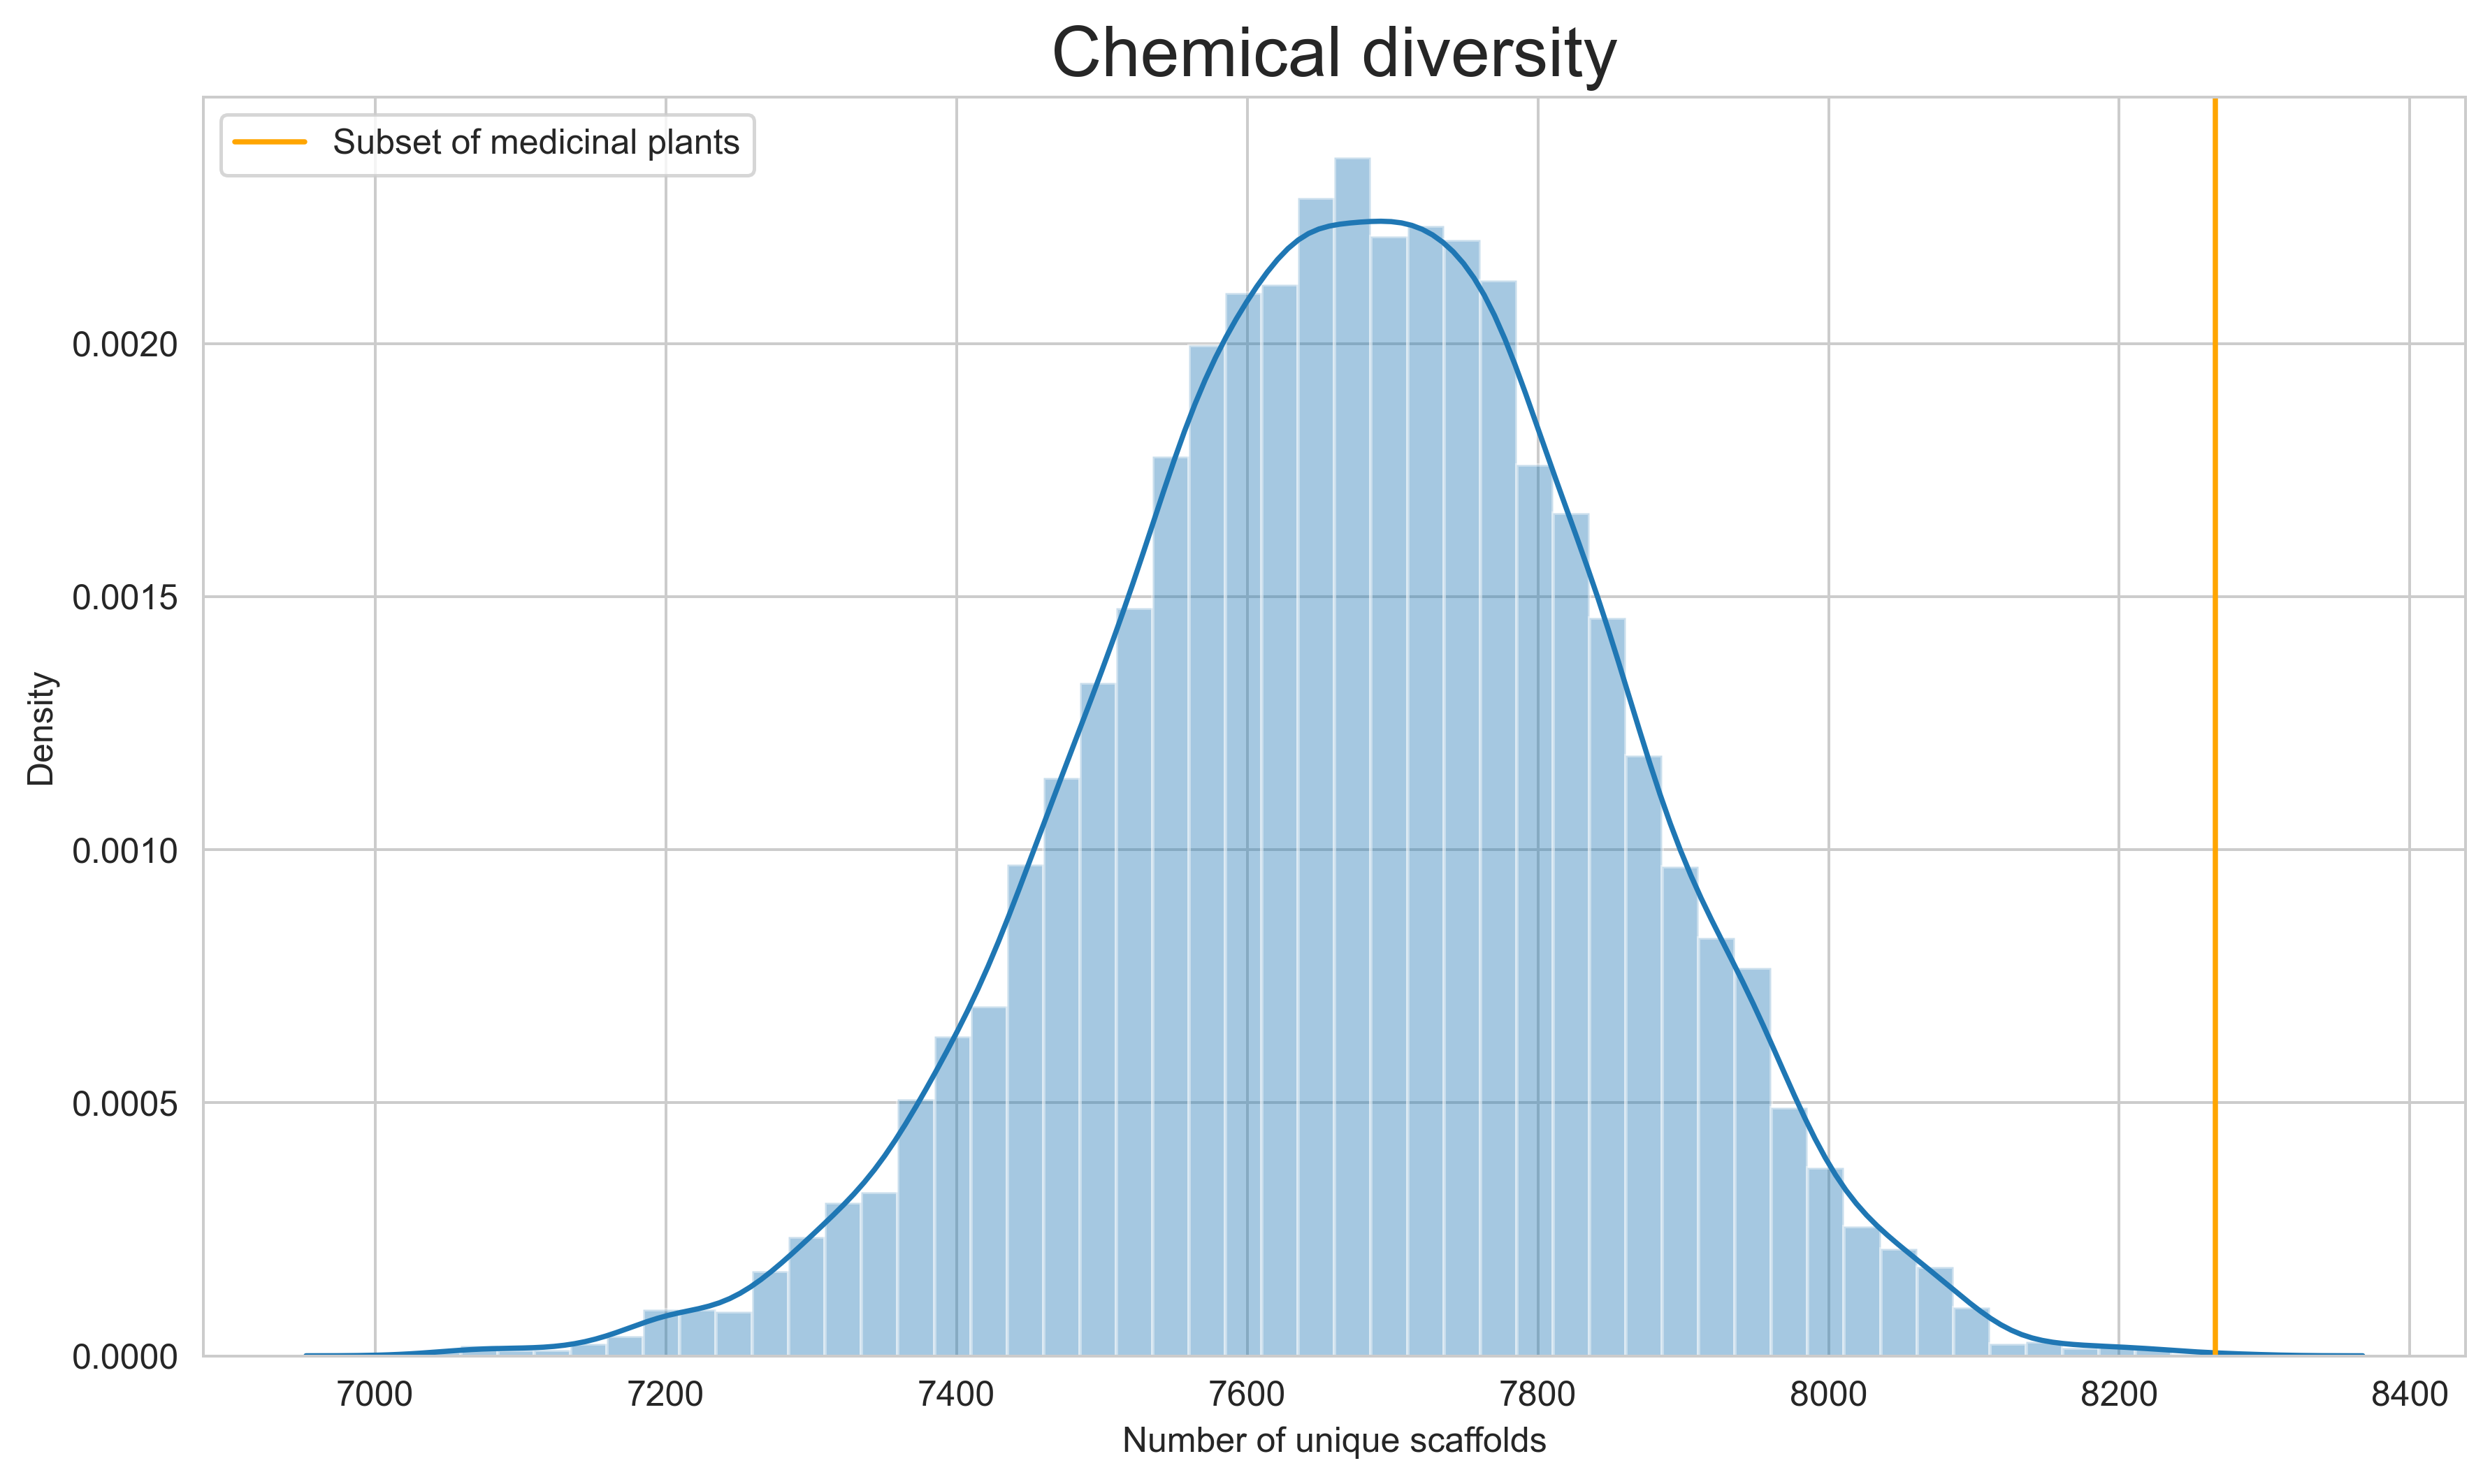

In [80]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.title('Chemical diversity', fontsize=20)
sns.distplot(
    unique_scaffolds_in_random_samples,
#     hist=False,
    ax=ax,
)

plt.axvline(
    unique_scaffolds_in_original_sample,
    0,
    label = 'Subset of medicinal plants',
    color = 'orange',
)
plt.xlabel('Number of unique scaffolds')
plt.legend()
plt.tight_layout()

plt.savefig(
    f'../data/figures/figure_6_d.png',
    dpi=400,
    bbox_inches='tight', 
)
plt.show()

### Ensuring the properties of the chemicals are maintained

In [43]:
df1 = pd.DataFrame([
    {
        "type": "Non medicinal plants",
        "molecular_weight": smiles_to_property_dict[chemical]['molecular_weight'],
        "logp": smiles_to_property_dict[chemical]['logp'],
        "fsp3": smiles_to_property_dict[chemical]['fsp3'],
        "topological_surface_area_mapping": smiles_to_property_dict[chemical]['topological_surface_area_mapping'],
    }
    for chemical in {
        chemical
        for plant, chemicals in plant_chem_dict.items()
        for chemical in chemicals
        if len(chemicals) < 100
    }
    if chemical in smiles_to_property_dict
])

df2 = pd.DataFrame([
    {
        "type": "Medicinal plants subset",
        "molecular_weight": smiles_to_property_dict[chemical]['molecular_weight'],
        "logp": smiles_to_property_dict[chemical]['logp'],
        "fsp3": smiles_to_property_dict[chemical]['fsp3'],
        "topological_surface_area_mapping": smiles_to_property_dict[chemical]['topological_surface_area_mapping'],
    }
    for chemical in chemicals_in_selected_sample
    if chemical in smiles_to_property_dict
])

chemical_properties_df = pd.concat([df1, df2])

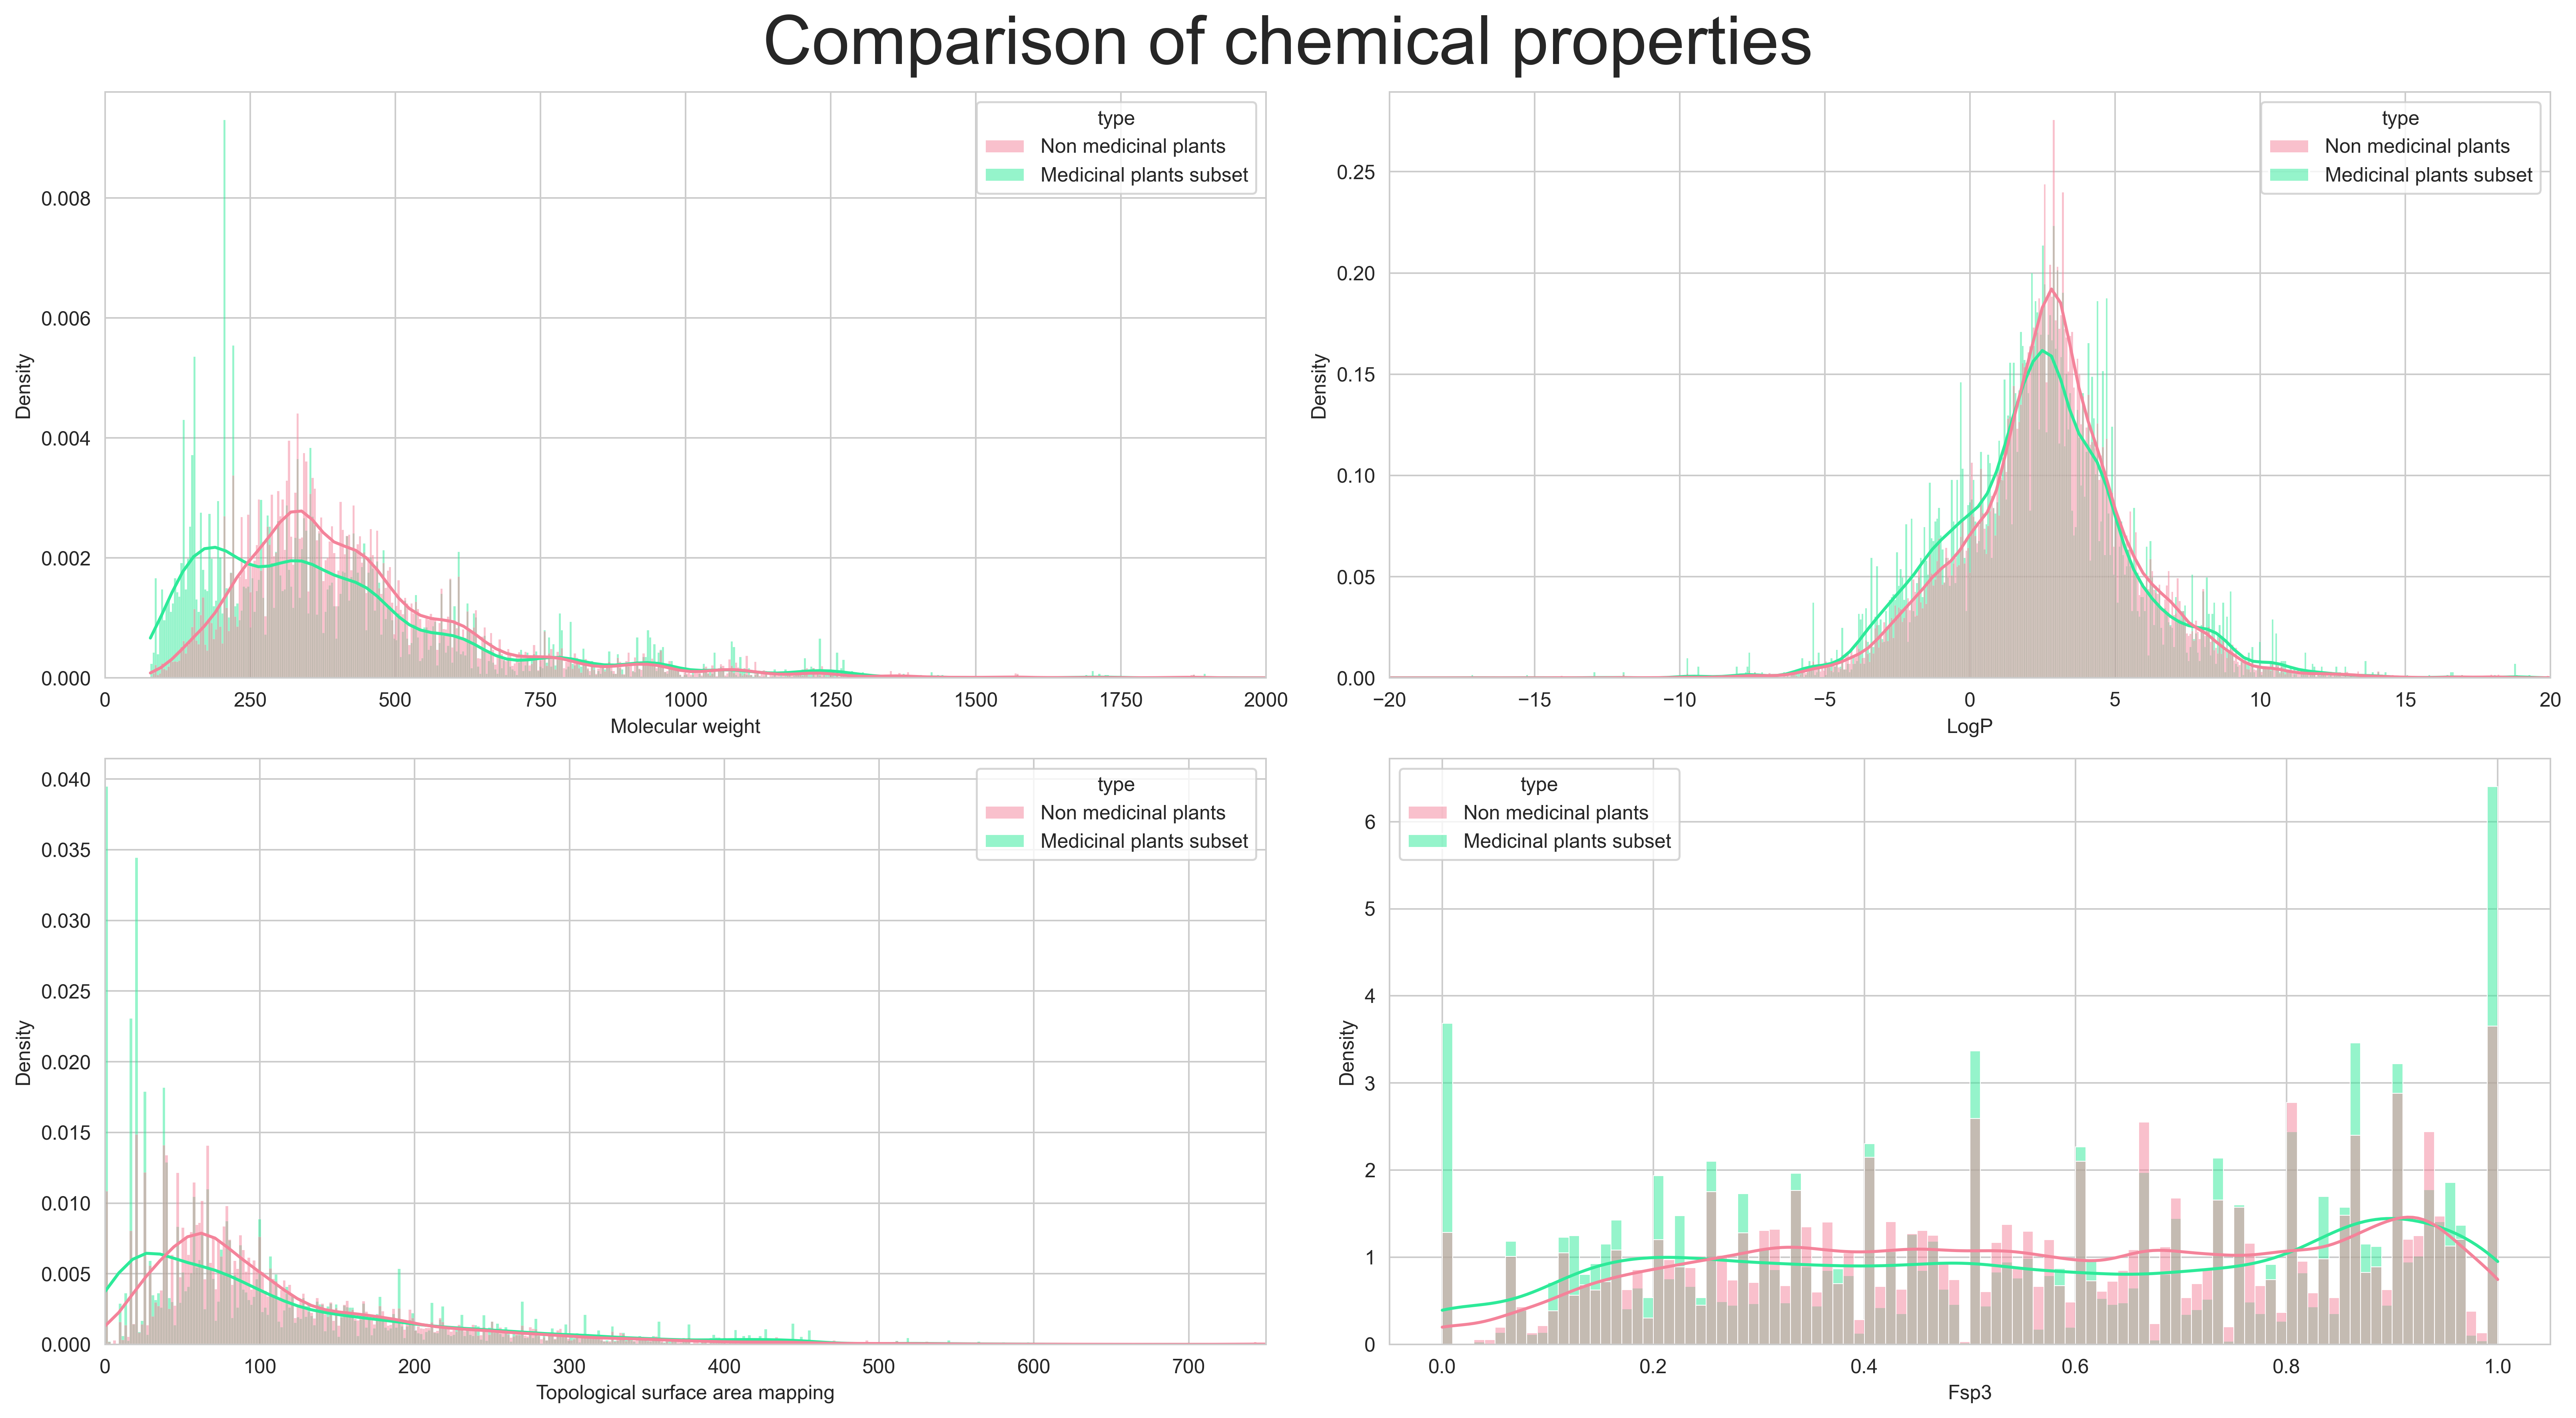

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

fig.suptitle('Comparison of chemical properties', fontsize=34)

sns.histplot(
    ax=axes[0, 0],
    data=chemical_properties_df,
    x='molecular_weight',
    hue='type',
    kde=True,
    common_norm=False,
    stat="density",
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants subset": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[0, 0].set(xlabel='Molecular weight')
axes[0, 0].set_xlim(0, 2000)

sns.histplot(
    ax=axes[0, 1],
    data=chemical_properties_df,
    x='logp',
    hue='type',
    kde=True,
    stat="density",
    common_norm=False,
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants subset": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[0, 1].set(xlabel='LogP')
axes[0, 1].set_xlim(-20, 20)

sns.histplot(
    ax=axes[1, 0],
    data=chemical_properties_df,
    x='topological_surface_area_mapping',
    hue='type',
    stat="density",
    kde=True,
    common_norm=False,
    bins=1000,
    alpha=0.5,
    palette={
        "Medicinal plants subset": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[1, 0].set(xlabel='Topological surface area mapping')
axes[1, 0].set_xlim(0, 750)

sns.histplot(
    ax=axes[1, 1],
    data=chemical_properties_df,
    x='fsp3',
    hue='type',
    kde=True,
    stat="density",
    common_norm=False,
    alpha=0.5,
    bins=100,
    palette={
        "Medicinal plants subset": '#2dea99',
        'Non medicinal plants': '#f4839a',
    },
)

axes[1, 1].set(xlabel='Fsp3')

plt.tight_layout()

plt.savefig(
    f'../data/figures/supplementary_figure_10.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()